# AI for Earth System Science Hackathon 2020
# HOLODEC Machine Learning Challenge Problem
Matt Hayman, Aaron Bansemer, David John Gagne, Gabrielle Gantos, Gunther Wallach, Natasha Flyer

## Introduction
<center><img src='holodec_images/image2.png'><center>

The properties of the water and ice particles in clouds are critical to many aspects of weather and climate.  The size, shape, and concentration of ice particles control the radiative properties of cirrus clouds.  The spatial distribution of water droplets in warm clouds may influence the formation of drizzle and rain.  The interactions among droplets, ice particles, and aerosols impact precipitation, lightning, atmospheric chemistry, and more.  Measurements of natural cloud particles are often taken aboard research aircraft with instruments mounted on the wings.  One of the newer technologies used for these instruments is inline holographic imaging, which has the important advantage of being able to instantaneously record all of the particles inside a small volume of air.  Using this technology, the Holographic Detector for Clouds (HOLODEC) has been developed by the university community and NCAR to improve our cloud measurement capabilities.

A hologram captures electro-magnatic field amplitude and phase (or wavefront) incident on a detector.  In contrast, standard imaging captures only the amplitude of the electric field.  Unlike a standard image, holograms can be computationally refocused on any object within the capture volume using standard wave propagation calculations. The figure below shows an example of an inline hologram (large image) with five out of focus particles.  The five smaller images show the reconstruction from each particle by computationally propagating the electro-magnetic field back to the depth position of each particle. 

<center><img src='holodec_images/image5.png'><center>

HOLODEC is an airborne holographic cloud imager capable of capturing particle size distributions in a single shot, so a measured particle size distribution is localized to a specific part of the cloud (not accumulated over a long path length).  By capturing a hologram, each particle can be imaged irrespective of its location in the sample volume, and its size and position can be accurately captured.

While holographic imaging provides unparalleled information about cloud particles, processing the raw holograms is also computationally expensive.  Lacking prior knowledge of the particle position in depth, a typical HOLODEC hologram is reconstructed at 1000 planes (or depths) using standard diffraction calculations.  At each plane, a particle’s image sharpness is evaluated and the particle size and position is determined only at a plane where it is in focus.  In addition to the computational cost, the processing requires human intervention to recognize when a “particle” is really just artifacts of interfering scattered fields.

The objective of this project is to develop a machine learning solution to process HOLODEC data that is more computationally efficient than the first-principles based processor.  

An important factor in processing hologram data is that the scattered field from a particle spreads out as it propagates.  The image below shows the scattered field from a 50 µm particle at distances in increments of 0.1 mm from the particle (0 to 0.7 mm).  As the scattered field expands, it’s power is also distributed over a larger area.

![holodec 3d](holodec_images/image1.png)

For simplicity, this project deals with simulated holographic data where particle shapes are limited to spheres.  Two datasets are provided.  The first dataset contains only one particle per hologram.  If you are successful in processing the first dataset, or you wish to immediately focus on a more challenging case, you can work on the second dataset that contains three particles per hologram.


## Software Requirements
This notebook requires Python >= 3.7. The following libraries are required:
* numpy
* scipy
* matplotlib
* xarray
* pandas
* scikit-learn
* tensorflow >= 2.1
* netcdf4
* h5netcdf
* tqdm
* s3fs
* zarr

In [1]:
!pip install numpy scipy matplotlib xarray pandas scikit-learn tensorflow netcdf4 h5netcdf tqdm s3fs zarr

In [2]:
# if working on google colab
#! pip install -U -q PyDrive
#from google.colab import drive
#drive.mount('/content/gdrive')

## Data
The datasets consist of synthetically-generated holograms of cloud droplets.  Each dataset is in zarr format, and contains a series of hologram images as well as the properties of each particle in the image.  The zarr variable names and properties are as follows:

| Variable Name | Description | Dimensions | Units/Range|
| ------------- | :----:|:----------- |:------|
| image  | Stack of single-color images. Each image is 600x400 pixels, ranging from 0-255 in intensity. | nHolograms, 600, 400 | 0 to 255 (grayscale image) |
| x  |  X-position of each particle in the dataset.  The origin is at the center of the hologram image. | nParticles (can vary) | -888 to 888 micrometers |
| y  | Y-position of each particle in the dataset.  The origin is at the center of the hologram image. |  nParticles (can vary) | -592 to 592 micrometers |
| z  | Z-position of each particle in the dataset.  The origin is at the focal plane of the instrument (all particles are unfocused). | nParticles (can vary) | 14000 to 158000 micrometers |
| d  | Diameter of each simulated droplet | nParticles (can vary) | 20 to 70 micrometers |
| hid | Hologram ID specifies which hologram this particle is contained in.  For example, if hid=1, the corresponding x, y, z, and d variables are found in the first hologram. | nParticles (can vary) | 1 to nHolograms |
| Dx (global attribute) | Resolution of each pixel, == 2.96 micrometers.  Use if you wish to convert x/y position to pixel number |  |  |

There are two datasets for this project, a single-particle dataset and a three-particle dataset.  The single-particle dataset only contains one particle per hologram (nHolograms = nParticles). There are 50,000 holograms in the training dataset that correspond to 50,000 particles.

The three-particle dataset contains three particles per hologram.  This dataset also contains 50,000 holograms but 150,000 particles.  Be sure to use the hid variable to figure out which hologram a particle is contained in.

The ultimate goal of this project is to be able to find particles in the holograms and determine their x, y, z, and d values. This process is straightforward for finding a single particle, but finding multiple particles and their properties is much more challenging. A simpler objective that could also assist in speeding up the HOLODEC processing is calculating the relative distribution of particle mass in the z-direction from the holograms, which is a combination of information from z and d. 

<center><img src='holodec_images/image4.png'><center>


### Potential Input Variables
| Variable Name | Units | Description | Relevance |
| ------------- | :----:|:----------- | :--------:|
| hologram   |  arbitrary |  8 bit (0-255) amplitude captured by CCD  | standard input data for processing  |


### Output Variables
| Variable Name | Units | Description |
| ------------- | :----:|:----------- |
| x  |  µm     |  particle horizontal position |
| y  |  µm     |  particle vertical position  |
| z  | µm  | particle position in depth (along the direction of propagation) |
| d  | µm  | particle diameter |
| hid | arbitrary | hologram ID by particle|


### Training Set

The single-particle training dataset is in the zarr format described above, with 15,000 holograms and 15,000 corresponding particles.

The three-particle training dataset contains 15,000 holograms and 45,000 particles.


### Validation Set
The single-particle validation dataset is in the zarr format described above, with 5,000 holograms and 5,000 corresponding particles.

The three-particle validation dataset contains 5,000 holograms and 15,000 particles.


### Test Set
The single-particle test dataset is in the zarr format described above, with 5,000 holograms and 5,000 corresponding particles.

The three-particle test dataset contains 5,000 holograms and 15,000 particles.


### Data Transforms

The input images only need to be normalized between 0 and 1 by dividing by 255. 


In [2]:
# Module imports 
import argparse
import random
import os
from os.path import join, exists
import sys
import s3fs
import yaml
import zarr
import xarray as xr
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, max_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, MaxPool2D
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.optimizers import Adam, SGD

seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

In [3]:
# Limit GPU memory usage
gpus = tf.config.get_visible_devices("GPU")
for device in gpus:
    print(device)
    tf.config.experimental.set_memory_growth(device, True)


PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
# define some datset helper functions

num_particles_dict = {
    1 : '1particle',
    3 : '3particle',
    'multi': 'multiparticle'}

split_dict = {
    'train' : 'training',
    'test'   : 'test',
    'valid': 'validation'}

def dataset_name(num_particles, split, file_extension='zarr'):
    """
    Return the dataset filename given user inputs
    
    Args: 
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
        file_extension: (str) Dataset file extension
    
    Returns:
        dataset: (str) Dataset name
    """
    
    valid = [1,3,'multi']
    if num_particles not in valid:
        raise ValueError("results: num_particles must be one of %r." % valid)
    num_particles = num_particles_dict[num_particles]
    
    valid = ['train','test','valid']
    if split not in valid:
        raise ValueError("results: split must be one of %r." % valid)
    split = split_dict[split]
    
    return f'synthetic_holograms_{num_particles}_{split}_small.{file_extension}'

def open_zarr(path_data, num_particles, split):
    """
    Open a HOLODEC Zarr file hosted on AWS
    
    Args: 
        path_data: (str) Path to directory containing datset
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi')
        split: (str) Dataset split of either 'train', 'valid', or 'test'
    
    Returns:
        dataset: (xarray Dataset) Opened dataset
    """
    path_data = os.path.join(path_data, dataset_name(num_particles, split))
    fs = s3fs.S3FileSystem(anon=True, default_fill_cache=False)
    store = s3fs.S3Map(root=path_data, s3=fs, check=False)
    dataset = xr.open_zarr(store=store)
    return dataset

def scale_images(images, scaler_vals=None):
    """
    Takes in array of images and scales pixel values between 0 and 1
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    
    if scaler_vals is None:
        scaler_vals = {}
        scaler_vals["min"] = images.min()
        scaler_vals["max"] = images.max()
    images_scaled = (images.astype(np.float32) - scaler_vals["min"]) / (scaler_vals["max"] - scaler_vals["min"])
    return images_scaled, scaler_vals

def load_scaled_datasets(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals


In [6]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"

#Does this load only the 3-particle data?
num_particles = 3
output_cols = ["hid", "x", "y", "z", "d"]
num_z_bins = 20
slice_idx = 6000


In [7]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled,\
train_outputs,\
scaler_vals = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols,
                                   slice_idx)

valid_inputs_scaled,\
valid_outputs, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals)

Slicing data into inputs/outputs
	- outputs.shape: (6000, 5)
Scaling input data
	- inputs_scaled.shape: (6000, 600, 400, 1)
Slicing data into inputs/outputs
	- outputs.shape: (2000, 5)
Scaling input data
	- inputs_scaled.shape: (2000, 600, 400, 1)


In [5]:
# Plot a single hologram with the particles overlaid
def plot_hologram(h, outputs,inputs):
    """
    Given a hologram number, plot hologram and particle point
    
    Args: 
        h: (int) hologram number
    
    Returns:
        print of pseudocolor plot of hologram and hologram particles
    """    
    x_vals = np.linspace(-888, 888, inputs[h, :, :, 0].shape[0])
    y_vals = np.linspace(-592, 592, inputs[h, :, :, 0].shape[1])

    plt.figure(figsize=(12, 8))
    plt.pcolormesh(x_vals, y_vals, inputs[h, :, :, 0].T, cmap="RdBu_r")
    h_particles = np.where(outputs["hid"] == h + 1)[0]
    for h_particle in h_particles:
        plt.scatter(outputs.loc[h_particle, "x"],
                    outputs.loc[h_particle, "y"],
                    outputs.loc[h_particle, "d"] ** 2,
                    outputs.loc[h_particle, "z"],
                    vmin=outputs["z"].min(),
                    vmax=outputs["z"].max(),
                    cmap="cool")
        plt.annotate(f"d: {outputs.loc[h_particle,'d']:.1f} µm",
                     (outputs.loc[h_particle, "x"], outputs.loc[h_particle, "y"]))
    plt.xlabel("horizontal particle position (µm)", fontsize=16)
    plt.ylabel("vertical particle position (µm)", fontsize=16)
    plt.title("Hologram and particle positions plotted in four dimensions", fontsize=20, pad=20)
    plt.colorbar().set_label(label="z-axis particle position (µm)", size=16)


In [6]:
h = 300
plot_hologram(h, train_outputs,train_inputs_scaled)
print(train_inputs_scaled[h,:,:,0])

NameError: name 'train_outputs' is not defined

## Baseline Machine Learning Model
A baseline model for solving this problem uses a ConvNET architecture implemented in Keras.  The first three convolution layers consist of 5 x 5 pixel kernels with rectified linear unit (relu) activation followed by a 4 x 4 pixel max pool layer.  The first convolution layer has 8 channels, the second contains 16 channels, and the third contains 32 channels.  The output of the third convolution layer is flattened and fed into a dense layer with 64 neurons and relu activation.  Finally the output layer consists of the relative mass in 20 bins.  The model is trained using a mean absolute error and categorical cross-entropy loss function.

Training time: 20 epochs in ~2.5 minutes


In [7]:
class Conv2DNeuralNetwork(object):
    """
    A Conv2D Neural Network Model that can support arbitrary numbers of layers.

    Attributes:
        filters: List of number of filters in each Conv2D layer
        kernel_sizes: List of kernel sizes in each Conv2D layer
        conv2d_activation: Type of activation function for conv2d layers
        pool_sizes: List of Max Pool sizes
        dense_sizes: Sizes of dense layers
        dense_activation: Type of activation function for dense layers
        output_activation: Type of activation function for output layer
        lr: Optimizer learning rate
        optimizer: Name of optimizer or optimizer object.
        adam_beta_1: Exponential decay rate for the first moment estimates
        adam_beta_2: Exponential decay rate for the first moment estimates
        sgd_momentum: Stochastic Gradient Descent momentum
        decay: Optimizer decay
        loss: Name of loss function or loss object
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
    def __init__(self, filters=(8,), kernel_sizes=(5,), conv2d_activation="relu",
                 pool_sizes=(4,), dense_sizes=(64,), dense_activation="relu", output_activation="softmax",
                 lr=0.001, optimizer="adam",  adam_beta_1=0.9, adam_beta_2=0.999,
                 sgd_momentum=0.9, decay=0, loss="mse", batch_size=32, epochs=2, verbose=0):
        self.filters = filters
        #self.kernel_sizes = [tuple((v,v)) for v in kernel_sizes]
        self.kernel_sizes = kernel_sizes
        self.conv2d_activation = conv2d_activation
        self.pool_sizes = [tuple((v,v)) for v in pool_sizes]
        self.dense_sizes = dense_sizes
        self.dense_activation = dense_activation
        self.output_activation = output_activation
        self.lr = lr
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.sgd_momentum = sgd_momentum
        self.decay = decay
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = None

    def build_neural_network(self, input_shape, output_shape):
        """Create Keras neural network model and compile it."""
        conv_input = Input(shape=(input_shape), name="input")
        nn_model = conv_input
        for h in range(len(self.filters)):
            nn_model = Conv2D(self.filters[h], self.kernel_sizes[h], padding="same",
                              activation=self.conv2d_activation, name=f"conv2D_{h:02d}")(nn_model)
            nn_model = MaxPool2D(self.pool_sizes[h], name=f"maxpool2D_{h:02d}")(nn_model)
        nn_model = Flatten()(nn_model)
        for h in range(len(self.dense_sizes)):
            nn_model = Dense(self.dense_sizes[h], activation=self.dense_activation, name=f"dense_{h:02d}")(nn_model)
        nn_model = Dense(output_shape, activation=self.output_activation, name=f"dense_output")(nn_model)
        self.model = Model(conv_input, nn_model)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        self.model.summary()

    def fit(self, x, y, xv, yv):
        if len(y.shape) == 1:
            output_shape = 1
        else:
            output_shape = y.shape[1]
        input_shape = x.shape[1:]
        self.build_neural_network(input_shape, output_shape)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs,
                       verbose=self.verbose, validation_data=(xv, yv))
        return self.model.history.history

    def predict(self, x):
        y_out = self.model.predict(x, batch_size=self.batch_size)
        return y_out

    def predict_proba(self, x):
        y_prob = self.model.predict(x, batch_size=self.batch_size)
        return y_prob


### Z Relative Particle Mass Model
This neural network is tasked to predict the distribution of particle mass in the z-plane of the instrument. The relative mass is calculated by calculating the volume of each sphere based on the area and dividing by the total mass of all particles. The advantage of this target is that it behaves like a probability density function and sums to 1, and it is agnostic to the number of particles in the image.


In [11]:
def calc_z_relative_mass(outputs, holograms, num_z_bins=20, z_bins=None):
    """
    Calculate z-relative mass from particle data.
    
    Args: 
        outputs: (np array) Output data previously specified by output_cols 
        holograms: (int) Number of holograms
        num_z_bins: (int) Number of bins for z_bins linspace
        z_bins: (np array) Bin linspace along the z-axis
    
    Returns:
        z_mass: (np array) Particle mass distribution by hologram
        z_bins: (np array) Bin linspace along the z-axis
    """
    
    if z_bins is None:
        z_bins = np.linspace(outputs["z"].min()- 100, outputs["z"].max() + 100, num_z_bins)
        print(z_bins)
    else:
        num_z_bins = z_bins.size
    z_mass = np.zeros((holograms, num_z_bins), dtype=np.float32)
    for i in range(outputs.shape[0]):
        z_pos = np.searchsorted(z_bins, outputs.loc[i, "z"], side="right") - 1
        mass = 4 / 3 * np.pi * (outputs.loc[i, "d"])**3
        z_mass[int(outputs.loc[i, "hid"]) - 1, z_pos] += mass
    z_mass /= np.expand_dims(z_mass.sum(axis=1), -1)
    print(f"z_mass.shape: {z_mass.shape}\nz_bins.shape: {z_bins.shape}")
    return z_mass, z_bins


In [12]:
z_bins = np.linspace(np.minimum(train_outputs["z"].min(), valid_outputs["z"].min()),
                     np.maximum(train_outputs["z"].max(), valid_outputs["z"].max()),
                     num_z_bins)
train_z_mass, _ = calc_z_relative_mass(train_outputs, len(train_outputs["hid"].unique()), z_bins=z_bins)
valid_z_mass, _ = calc_z_relative_mass(valid_outputs, len(valid_outputs["hid"].unique()), z_bins=z_bins)
train_inputs_scaled = train_inputs_scaled[0::3]
valid_inputs_scaled = train_inputs_scaled[0::3]

z_mass.shape: (2000, 20)
z_bins.shape: (20,)
z_mass.shape: (667, 20)
z_bins.shape: (20,)


### Three particle, z-mass model definition

In [13]:
# conv2d_network definitions for 3 particle z mass solution

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/3particle_base"
else:
    path_out = "./holodec_models/3particle_base/"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "cnn"
filters = [16, 24, 32]
kernel_sizes = [5, 5, 5]
conv2d_activation = "relu"
pool_sizes = [4, 4, 4]
dense_sizes = [64, 32]
dense_activation = "elu"
lr = 0.0003
decay = 0.1
optimizer = "adam"
loss = "categorical_crossentropy"
batch_size = 128
epochs = 40
verbose = 1

seed = 328942
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)


In [14]:
# 3 particle z mass model build, compile, fit, and predict

three_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes,
                              conv2d_activation=conv2d_activation,
                              pool_sizes=pool_sizes, dense_sizes=dense_sizes,
                              dense_activation=dense_activation, lr=lr,
                              optimizer=optimizer, decay=decay, loss=loss,
                              batch_size=batch_size, epochs=epochs, verbose=verbose)
    hist = mod.fit(train_inputs_scaled, train_z_mass, valid_inputs_scaled, valid_z_mass)
    
    train_z_mass_pred = mod.predict(train_inputs_scaled)
    valid_z_mass_pred = mod.predict(valid_inputs_scaled)
print(f"Running model took {datetime.now() - three_start} time")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 600, 400, 1)]     0         
_________________________________________________________________
conv2D_00 (Conv2D)           (None, 600, 400, 16)      416       
_________________________________________________________________
maxpool2D_00 (MaxPooling2D)  (None, 150, 100, 16)      0         
_________________________________________________________________
conv2D_01 (Conv2D)           (None, 150, 100, 24)      9624      
_________________________________________________________________
maxpool2D_01 (MaxPooling2D)  (None, 37, 25, 24)        0         
_________________________________________________________________
conv2D_02 (Conv2D)           (None, 37, 25, 32)        19232     
_________________________________________________________________
maxpool2D_02 (MaxPooling2D)  (None, 9, 6, 32)          0     

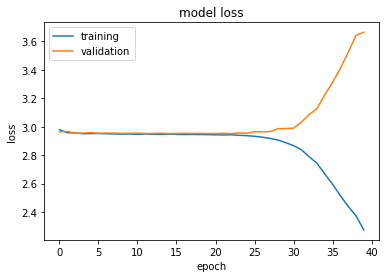

In [15]:
# visualize loss history
#steal this for later use!
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [16]:
# save the model
print("Saving the model")
mod.model.save(join(path_out, model_name +".h5"))

Saving the model


In [17]:
# clear your tf session without needing to re-load and re-scale data

del mod
tf.keras.backend.clear_session()


### Three Particle Metrics

How well do individual predictions (red) match with the actual particle locations (blue)?


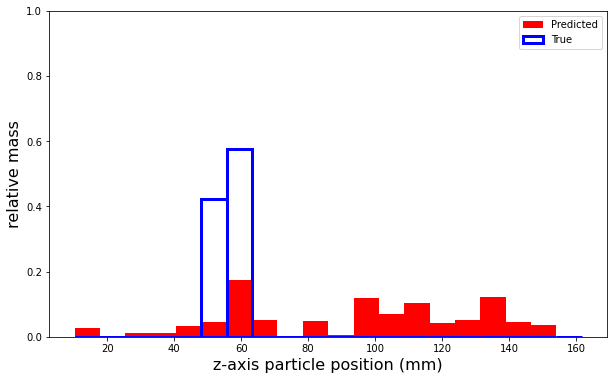

In [18]:
valid_index = 11
bin_size = z_bins[1] - z_bins[0]
plt.figure(figsize=(10, 6))
plt.bar(z_bins / 1000, valid_z_mass_pred[valid_index], bin_size / 1000, color='red', label="Predicted")
plt.bar(z_bins / 1000, valid_z_mass[valid_index], bin_size / 1000, edgecolor='blue', facecolor="none", lw=3, label="True")
plt.ylim(0, 1)
plt.xlabel("z-axis particle position (mm)", fontsize=16)
plt.ylabel("relative mass", fontsize=16)
plt.legend(loc="best")

If the model was completely unbiased, then mean relative mass in each bin should be nearly the same across all validation examples. In this case we see that the CNN preferentially predicts that the mass is closer to the camera, likely due to a combination of particles closer to the camera blocking those farther away along with more distant particles influencing the entire image. Since the CNN assumes image properties are more localized, it will struggle to detect the particles that are farther away.

Text(0, 0.5, 'Mean Relative Mass')

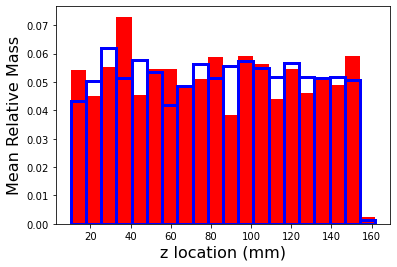

In [19]:
plt.bar(z_bins / 1000, valid_z_mass_pred.mean(axis=0), (z_bins[1] - z_bins[0]) / 1000, color='red')
plt.bar(z_bins / 1000, valid_z_mass.mean(axis=0), (z_bins[1]-z_bins[0]) / 1000, edgecolor='blue', facecolor="none", lw=3)
plt.xlabel("z location (mm)", fontsize=16)
plt.ylabel("Mean Relative Mass", fontsize=16)

In [8]:
def ranked_probability_score(y_true, y_pred):
    return np.mean((np.cumsum(y_true, axis=1) - np.cumsum(y_pred, axis=1)) ** 2) / (y_true.shape[1] -1)

In [21]:
rps_nn = ranked_probability_score(valid_z_mass, valid_z_mass_pred)
rps_climo = ranked_probability_score(valid_z_mass, np.ones(valid_z_mass_pred.shape) / valid_z_mass_pred.shape[1])
print(rps_nn, rps_climo)
rpss = 1 - rps_nn / rps_climo
print(f"RPSS: {rpss:0.3f}")

0.005035203538442913 0.0040226233885724905
RPSS: -0.252


### One Particle Model
An easier problem is predicting the location and properties of synthetic single particles.


In [9]:
# data definitions

path_data = "ncar-aiml-data-commons/holodec/"
num_particles = 1
output_cols_one  = ["x", "y", "z", "d"]
scaler_one = MinMaxScaler()
slice_idx = 6000


In [11]:
# load and normalize data (this takes approximately 2 minutes)
train_inputs_scaled_one,\
train_outputs_one,\
scaler_vals = load_scaled_datasets(path_data,
                                   num_particles,
                                   output_cols_one,
                                   slice_idx)

valid_inputs_scaled_one,\
valid_outputs_one, _ = load_scaled_datasets(path_data,
                                        num_particles,
                                        output_cols_one,
                                        slice_idx,
                                        split='valid',
                                        scaler_vals=scaler_vals)

# extra transform step for output_cols_one in lieu of z mass

train_outputs_scaled_one = scaler_one.fit_transform(train_outputs_one[output_cols_one])
valid_outputs_scaled_one = scaler_one.transform(valid_outputs_one[output_cols_one])


Slicing data into inputs/outputs
	- outputs.shape: (6000, 4)
Scaling input data
	- inputs_scaled.shape: (6000, 600, 400, 1)
Slicing data into inputs/outputs
	- outputs.shape: (2000, 4)
Scaling input data
	- inputs_scaled.shape: (2000, 600, 400, 1)


In [12]:
# conv2d_network definitions for 1 particle 4D solution

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/1particle_base"
else:
    path_out = "./holodec_models/1particle_base/"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "cnn"
filters = [16, 24, 32]
kernel_sizes = [5, 5, 5]
conv2d_activation = "relu"
pool_sizes = [4, 4, 4]
dense_sizes = [64, 32]
dense_activation = "relu"
lr = 0.0001
optimizer = "adam"
loss = "mae"
batch_size = 128
epochs = 20
verbose = 1

if not exists(path_out):
    os.makedirs(path_out)


In [13]:
# 1 particle 4D model build, compile, fit, and predict

one_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes, conv2d_activation=conv2d_activation,
                     pool_sizes=pool_sizes, dense_sizes=dense_sizes, dense_activation=dense_activation,
                     lr=lr, optimizer=optimizer, loss=loss, batch_size=batch_size, epochs=epochs, verbose=verbose)
    mod.fit(train_inputs_scaled_one, train_outputs_scaled_one, valid_inputs_scaled_one, valid_outputs_scaled_one)
    
    train_preds_scaled_one = pd.DataFrame(mod.predict(train_inputs_scaled_one), columns=output_cols_one)
    valid_preds_scaled_one = pd.DataFrame(mod.predict(valid_inputs_scaled_one), columns=output_cols_one)
print(f"Running model took {datetime.now() - one_start} time")


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 600, 400, 1)]     0         
_________________________________________________________________
conv2D_00 (Conv2D)           (None, 600, 400, 16)      416       
_________________________________________________________________
maxpool2D_00 (MaxPooling2D)  (None, 150, 100, 16)      0         
_________________________________________________________________
conv2D_01 (Conv2D)           (None, 150, 100, 24)      9624      
_________________________________________________________________
maxpool2D_01 (MaxPooling2D)  (None, 37, 25, 24)        0         
_________________________________________________________________
conv2D_02 (Conv2D)           (None, 37, 25, 32)        19232     
_________________________________________________________________
maxpool2D_02 (MaxPooling2D)  (None, 9, 6, 32)          0     

In [14]:
# inverse transform of scaled predictions

train_preds_one = pd.DataFrame(scaler_one.inverse_transform(train_preds_scaled_one.values), columns=output_cols_one)
valid_preds_one = pd.DataFrame(scaler_one.inverse_transform(valid_preds_scaled_one.values), columns=output_cols_one)


### One Particle Metrics
An ideal solution to HOLODEC processing would leverage all the advantages of the instrument (unparalleled particle position and size accuracy) but reduce the drawbacks (processing time).  For this reason, the major components of the model assessment should include:

Mean absolute error in predictions for single-particle dataset:

| Variable Name | Error |
| ------------- |:----------- |
| x  |  20 µm     |
| y  |  12 µm     |
| z  |  2519 µm     |
| d  |  1 µm     |



In [15]:
# calculate error by output_cols_one

valid_maes_one = np.zeros(len(output_cols_one))
max_errors_one = np.zeros(len(output_cols_one))
for o, output_col in enumerate(output_cols_one):
    valid_maes_one[o] = mean_absolute_error(valid_outputs_one[output_col], valid_preds_one[output_col])
    max_errors_one[o] = max_error(valid_outputs_one[output_col], valid_preds_one[output_col])

    print(f"{output_col} MAE: {valid_maes_one[o]:,.0f} µm \t\t Max Error: {max_errors_one[o]:,.0f} µm")


x MAE: 305 µm 		 Max Error: 1,038 µm
y MAE: 209 µm 		 Max Error: 816 µm
z MAE: 49,569 µm 		 Max Error: 139,723 µm
d MAE: 16 µm 		 Max Error: 50 µm


## Hackathon Challenges

### Monday
* Load the data
* Create an exploratory visualization of the data
* Test two different transformation and scaling methods
* Test one dimensionality reduction method
* Train a linear model
* Train a decision tree ensemble method of your choice

Text(0.5, 1.0, 'Distribution of sizes in training data')

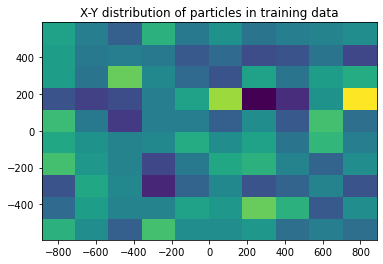

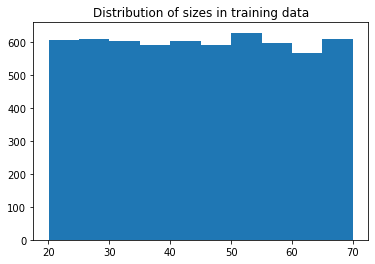

In [28]:
# Data is pretty much loaded by the preceding code it seems, but re-stating below
#one-particle training data loaded as: train_inputs_scaled_one, train_outputs_one, scaler_vals_one
#Validation data same, valid_inputs_scaled_one, valid_outputs_one, scaler vals as "_" an odd name, possibly just a dump name

#perhaps a helpful method of explanatory visualization of the data would be a x-y heatmap of particles?
#print(train_outputs_one.d)
#exploratory data visualization
plt.figure(1)
plt.hist2d(train_outputs_one.x,train_outputs_one.y)
plt.title('X-Y distribution of particles in training data')
plt.figure(2)
plt.hist(train_outputs_one.d)
plt.title("Distribution of sizes in training data")

In [29]:
#grab the scaling models for adjustment
#Try a scaling that also clips the data, as a dimensionality reduction technique
def scale_images_local(images, scaler_vals=None):
    """
    Takes in array of images and scales pixel s.t. Each image is binary as above or below average
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    

    images_scaled = []
    
    for i in range(len(images)):
        image = images[i]
        imavg = np.average(image)
        #immax = image.max()
        newimage = np.clip(image,imavg,imavg+1)
        images_scaled += [newimage]
    images_scaled = np.array(images_scaled)
        
    return images_scaled, scaler_vals

def scale_images_fullrange(images, scaler_vals=None):
    """
    Takes in array of images and scales such that the full range of 0 to 255 is used
    
    Args: 
        images: (np array) Array of images 
        scaler_vals: (dict) Image scaler 'max' and 'min' values
        
    Returns:
        images_scaled: (np array) Scaled array of images with pixel values between 0 and 1
        scaler_vals: (dict) Image scaler 'max' and 'min' values
    """
    
    images_scaled = (images.astype(np.float32) - 0) / (255)
        
    return images_scaled, scaler_vals

def load_scaled_datasets_local(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images_local(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images_local(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals

def load_scaled_datasets_fullrange(path_data, num_particles, output_cols, slice_idx,
                         split='train', scaler_vals=None):
    """
    Given a path to training or validation datset, the number of particles per
    hologram, and output columns, returns scaled inputs and raw outputs.
    
    Args: 
        path_data: (str) Path to directory containing training and validation datsets
        num_particles: (int or str) Number of particles per hologram (1, 3, or 'multi') 
        output_cols: (list of strings) List of feature columns to be used
        
    Returns:
        inputs_scaled: (np array) Input data scaled between 0 and 1
        outputs: (df) Output data specified by output_cols
        scaler_vals: (dict) list of training/validation/test files
    """
    
    if split == 'valid':
      slice_idx = int(slice_idx/3)
    print("Slicing data into inputs/outputs")
    ds = open_zarr(path_data, num_particles, split)
    inputs = ds["image"].values[:slice_idx]
    outputs = ds[output_cols].to_dataframe().loc[:slice_idx-1,:]
    ds.close()
    print(f"\t- outputs.shape: {outputs.shape}")

    print("Scaling input data")
    if split == 'train':
      inputs_scaled, scaler_vals = scale_images_fullrange(inputs)
    else:
      slice_idx = int(slice_idx/3)
      inputs_scaled, _ = scale_images_fullrange(inputs, scaler_vals)
  
    inputs_scaled = np.expand_dims(inputs_scaled, -1)
    print(f"\t- inputs_scaled.shape: {inputs_scaled.shape}")

    return inputs_scaled, outputs, scaler_vals

train_inputs_scaled_one_local,\
train_outputs_one_local,\
scaler_vals_one_local = load_scaled_datasets_local(path_data,
                                   num_particles,
                                   output_cols,
                                   slice_idx)

train_inputs_scaled_one_fullrange,\
train_outputs_one_fullrange,\
scaler_vals_one_fullrange = load_scaled_datasets_fullrange(path_data,
                                   num_particles,
                                   output_cols,
                                   slice_idx)

# extra transform step for output_cols_one in lieu of z mass
#I dont know what this does

#train_outputs_scaled_one_local = scaler_one.fit_transform(train_outputs_one[output_cols_one])
#train_outputs_scaled_one_fullrange = scaler_one.transform(train_outputs_one[output_cols_one])


Slicing data into inputs/outputs
	- outputs.shape: (6000, 5)
Scaling input data
	- inputs_scaled.shape: (6000, 600, 400, 1)
Slicing data into inputs/outputs
	- outputs.shape: (6000, 5)
Scaling input data
	- inputs_scaled.shape: (6000, 600, 400, 1)


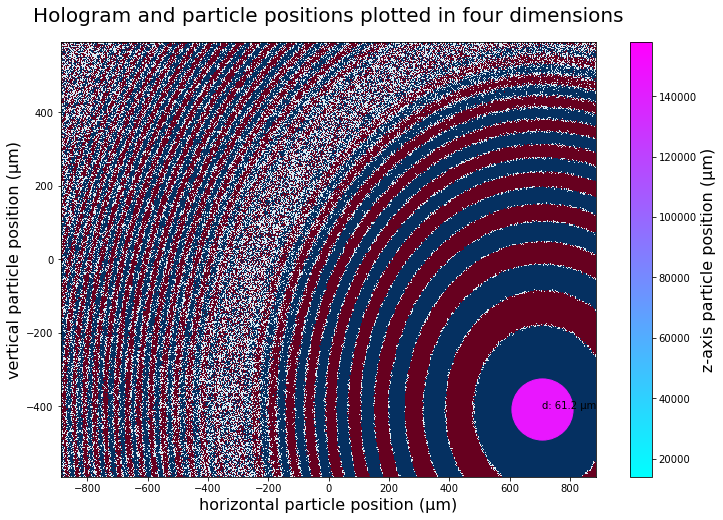

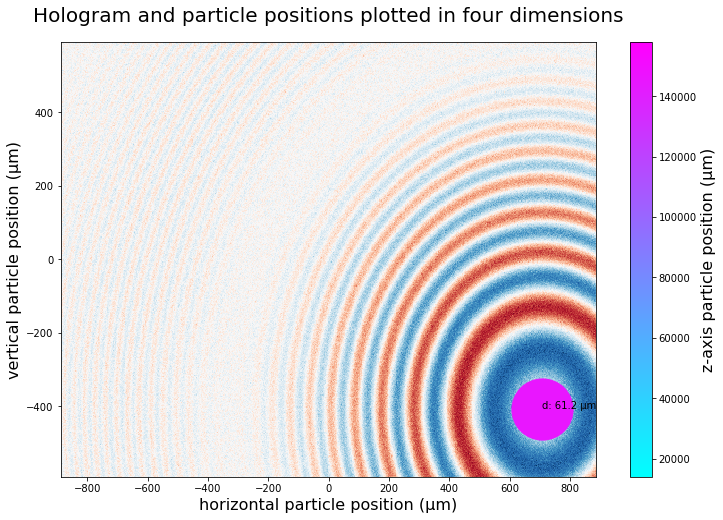

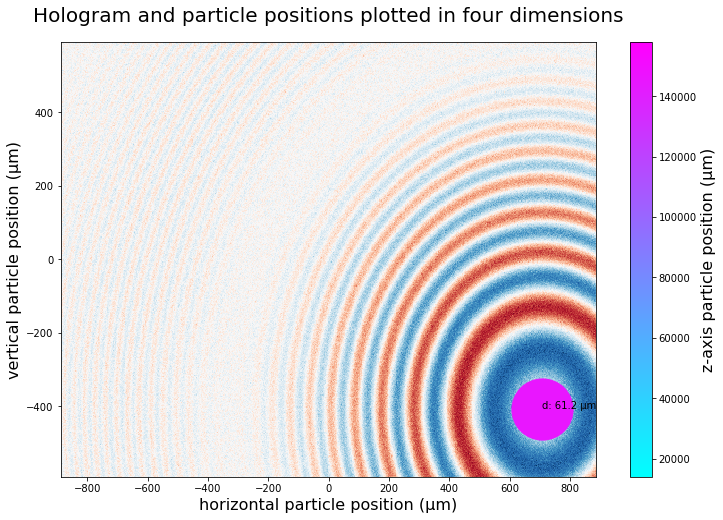

In [30]:
#check the differences between the two
h=500
plot_hologram(h, train_outputs_one_local,train_inputs_scaled_one_local)
plot_hologram(h, train_outputs_one_fullrange,train_inputs_scaled_one_fullrange)
plot_hologram(h,train_outputs_one,train_inputs_scaled_one)

### Tuesday
* Train a densely connected neural network
* Train a convolutional or recurrent neural network (depends on problem)
* Experiment with different architectures

In [31]:
# Tuesday's code goes here
#start with a  dense Neural Network
class DenseNeuralNetwork(object):
    """
    A DENSE Neural Network Model that can support arbitrary numbers of layers.

    Attributes:
        pool_sizes: List of Max Pool sizes
        dense_sizes: Sizes of dense layers
        dense_activation: Type of activation function for dense layers
        output_activation: Type of activation function for output layer
        lr: Optimizer learning rate
        optimizer: Name of optimizer or optimizer object.
        adam_beta_1: Exponential decay rate for the first moment estimates
        adam_beta_2: Exponential decay rate for the first moment estimates
        sgd_momentum: Stochastic Gradient Descent momentum
        decay: Optimizer decay
        loss: Name of loss function or loss object
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
    def __init__(self,
                 pool_sizes=(4,), dense_sizes=(64,), dense_activation="relu", output_activation="softmax",
                 lr=0.001, optimizer="adam",  adam_beta_1=0.9, adam_beta_2=0.999,
                 sgd_momentum=0.9, decay=0, loss="mse", batch_size=32, epochs=2, verbose=0):
        self.pool_sizes = [tuple((v,v)) for v in pool_sizes]
        self.dense_sizes = dense_sizes
        self.dense_activation = dense_activation
        self.output_activation = output_activation
        self.lr = lr
        self.optimizer = optimizer
        self.optimizer_obj = None
        self.adam_beta_1 = adam_beta_1
        self.adam_beta_2 = adam_beta_2
        self.sgd_momentum = sgd_momentum
        self.decay = decay
        self.loss = loss
        self.batch_size = batch_size
        self.epochs = epochs
        self.verbose = verbose
        self.model = None

    def build_neural_network(self, input_shape, output_shape):
        """Create Keras neural network model and compile it."""
        dense_input = Input(shape=(input_shape), name="input")
        dense_model = dense_input
        dense_model = Flatten()(dense_model)
        for h in range(len(self.dense_sizes)):
            dense_model = Dense(self.dense_sizes[h], activation=self.dense_activation, name=f"dense_{h:02d}")(dense_model)
        dense_model = Dense(output_shape, activation=self.output_activation, name=f"dense_output")(dense_model)
        self.model = Model(dense_input, dense_model)
        if self.optimizer == "adam":
            self.optimizer_obj = Adam(lr=self.lr, beta_1=self.adam_beta_1, beta_2=self.adam_beta_2, decay=self.decay)
        elif self.optimizer == "sgd":
            self.optimizer_obj = SGD(lr=self.lr, momentum=self.sgd_momentum, decay=self.decay)
        self.model.compile(optimizer=self.optimizer, loss=self.loss)
        self.model.summary()

    def fit(self, x, y, xv, yv):
        if len(y.shape) == 1:
            output_shape = 1
        else:
            output_shape = y.shape[1]
        input_shape = x.shape[1:]
        self.build_neural_network(input_shape, output_shape)
        self.model.fit(x, y, batch_size=self.batch_size, epochs=self.epochs,
                       verbose=self.verbose, validation_data=(xv, yv))
        return self.model.history.history

    def predict(self, x):
        y_out = self.model.predict(x, batch_size=self.batch_size)
        return y_out

    def predict_proba(self, x):
        y_prob = self.model.predict(x, batch_size=self.batch_size)
        return y_prob

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/1particle_base"
else:
    path_out = "./holodec_models/1particle_base/"
if not exists(path_out):
    os.makedirs(path_out)
model_name = "cnn"
pool_sizes = [4, 4, 4]
dense_sizes = [12,12]
dense_activation = "relu"
lr = 0.001
optimizer = "adam"
loss = "mae"
batch_size = 128
epochs = 5
verbose = 1

if not exists(path_out):
    os.makedirs(path_out)



In [ ]:
one_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod_dens = DenseNeuralNetwork(pool_sizes=pool_sizes, dense_sizes=dense_sizes, dense_activation=dense_activation,
                     lr=lr, optimizer=optimizer, loss=loss, batch_size=batch_size, epochs=epochs, verbose=verbose)
    mod_dens.fit(train_inputs_scaled_one, train_outputs_scaled_one, valid_inputs_scaled_one, valid_outputs_scaled_one)
    
    train_preds_scaled_one = pd.DataFrame(mod_dens.predict(train_inputs_scaled_one), columns=output_cols_one)
    valid_preds_scaled_one = pd.DataFrame(mod_dens.predict(valid_inputs_scaled_one), columns=output_cols_one)
print(f"Running model took {datetime.now() - one_start} time")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 600, 400, 1)]     0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 240000)            0         
_________________________________________________________________
dense_00 (Dense)             (None, 12)                2880012   
_________________________________________________________________
dense_01 (Dense)             (None, 12)                156       
_________________________________________________________________
dense_output (Dense)         (None, 4)                 52        
Total params: 2,880,220
Trainable params: 2,880,220
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
47/47 [==============================] - 4s 94ms/step - loss: 0.4960 - val_loss: 0.4997
Epoch 2/5
47/47 [

In [ ]:
print(train_preds_scaled_one)
print(train_outputs_one)
#unshockingly, these are bad at this. Lets be better

In [18]:
#define an improved 2d Convolutional NN Model
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    path_out = "/content/gdrive/My Drive/micro_models/1particle_base"
else:
    path_out = "./holodec_models/1particle_base/"
if not exists(path_out):
    os.makedirs(path_out)

#class def
"""
    A Conv2D Neural Network Model that can support arbitrary numbers of layers.

    Attributes:
        filters: List of number of filters in each Conv2D layer
        kernel_sizes: List of kernel sizes in each Conv2D layer
        conv2d_activation: Type of activation function for conv2d layers
        pool_sizes: List of Max Pool sizes
        dense_sizes: Sizes of dense layers
        dense_activation: Type of activation function for dense layers
        output_activation: Type of activation function for output layer
        lr: Optimizer learning rate
        optimizer: Name of optimizer or optimizer object.
        adam_beta_1: Exponential decay rate for the first moment estimates
        adam_beta_2: Exponential decay rate for the first moment estimates
        sgd_momentum: Stochastic Gradient Descent momentum
        decay: Optimizer decay
        loss: Name of loss function or loss object
        batch_size: Number of examples per batch
        epochs: Number of epochs to train
        verbose: Level of detail to provide during training
        model: Keras Model object
    """
model_name = "cnn_imp"
#original value [16,24,32]
filters = [16, 16, 24, 32]
#original: [5,5,5]
#kernals dont have to be square, why should they?
kernel_sizes = [(2,6),(6,2), 5, 5]
#original: 'relu'
conv2d_activation = "relu"
#original[4,4,4]
pool_sizes = [4, 4, 4,4]
#original[64,32]
dense_sizes = [64, 32]
#original "relu"
dense_activation = "relu"
#original 0.0001
lr = 0.0001
#originals "adam", "mae"
optimizer = "adam"
loss = "mae"

batch_size = 128
epochs = 20
verbose = 1

if not exists(path_out):
    os.makedirs(path_out)
    
one_start = datetime.now()
with tf.device('/device:GPU:0'):
    mod_2dimp = Conv2DNeuralNetwork(filters=filters, kernel_sizes=kernel_sizes, conv2d_activation=conv2d_activation,
                     pool_sizes=pool_sizes, dense_sizes=dense_sizes, dense_activation=dense_activation,
                     lr=lr, optimizer=optimizer, loss=loss, batch_size=batch_size, epochs=epochs, verbose=verbose)
    hist2d_imp = mod_2dimp.fit(train_inputs_scaled_one, train_outputs_scaled_one, valid_inputs_scaled_one, valid_outputs_scaled_one)
    
    train_preds_scaled_one_imp = pd.DataFrame(mod_2dimp.predict(train_inputs_scaled_one), columns=output_cols_one)
    valid_preds_scaled_one_imp = pd.DataFrame(mod_2dimp.predict(valid_inputs_scaled_one), columns=output_cols_one)
print(f"Running model took {datetime.now() - one_start} time")


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 600, 400, 1)]     0         
_________________________________________________________________
conv2D_00 (Conv2D)           (None, 600, 400, 16)      208       
_________________________________________________________________
maxpool2D_00 (MaxPooling2D)  (None, 150, 100, 16)      0         
_________________________________________________________________
conv2D_01 (Conv2D)           (None, 150, 100, 16)      3088      
_________________________________________________________________
maxpool2D_01 (MaxPooling2D)  (None, 37, 25, 16)        0         
_________________________________________________________________
conv2D_02 (Conv2D)           (None, 37, 25, 24)        9624      
_________________________________________________________________
maxpool2D_02 (MaxPooling2D)  (None, 9, 6, 24)          0   

In [17]:
plt.plot(hist2d_imp['loss'])
plt.plot(hist2d_imp['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

NameError: name 'hist' is not defined

### Wednesday
* Calculate three relevant evaluation metrics for each ML solution and baseline
* Refine machine learning approaches and test additional hyperparameter settings

In [ ]:
# Wednesday's code goes here


### Thursday 
* Evaluate two interpretation methods for your machine learning solution
* Compare interpretation of baseline with your approach
* Submit best results on project to leaderboard
* Prepare 2 Google Slides on team's approach and submit them

In [ ]:
# Thursday's code goes here


## Ultimate Submission Code
Please insert your full data processing and machine learning pipeline code in the cell below.